In [1]:
from math import tau
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import pandas as pd
import scipy as sp
import scipy.signal as ss

plt.style.use('seaborn-notebook')
np.random.seed(293710966)

# Esempio 3.14 (ESPRIT)

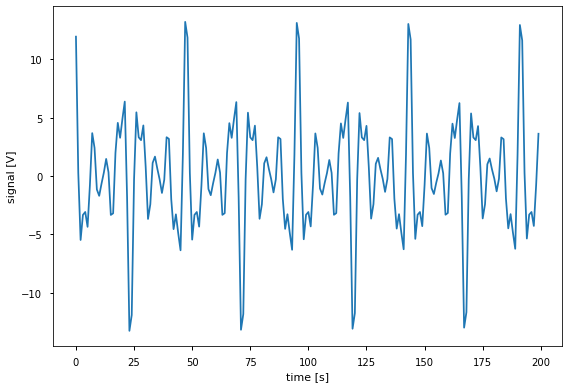

In [2]:
magnitudes = pd.read_csv('./harmonic-voltage-magnitude.csv', index_col='number')['typical']
phases = np.radians(pd.read_csv('./phases.csv', index_col='number'))['3.9']
dampings = pd.read_csv('./scaled-damping-factors.csv', index_col='number')

power_freq = 50
sampling_freq = 2400
harmonic_numbers = np.arange(3, 14, 2)

time = np.arange(4800.)

noise = 0.001 * np.random.normal(0, 1, time.size)
signal = noise.copy()

for n in harmonic_numbers:
    amp = magnitudes[n]
    phase = phases[n]
    damp = dampings['3.14'][n] / sampling_freq
    omega = tau * n * power_freq / sampling_freq
    signal += amp * np.exp(-damp * time) * np.cos(omega * time + phase)

fig, ax = plt.subplots()
ax.plot(time[:200], signal[:200])
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
fig.tight_layout()

In [3]:
time_window = 48 * 4
data_size = signal.size - time_window + 1

windows = [signal[i : i + time_window] for i in range(data_size)]
data_matrix = np.vstack(windows)

## Matrice delle Basi Ortogonali
La matrice $U$ viene ricavata mediante Decomposizione ai Valori Singolari (SVD) della matrice dei campionamenti $R_v$

In [4]:
U, _, _ = LA.svd(data_matrix)
Us = U[:, :6]
U1 = Us[:time_window-1]
U2 = Us[-time_window+1:]

La matrice $U$ viene poi partizionata estraendo le prime e ultime $\left( M - 1 \right)$ colonne.

## Stima per Minimi Quadrati (LS) di $\Psi$
$$
\hat{\Psi}_{LS} = \left( U_1^H U_1 \right)^{-1} U_1^H U_2
$$

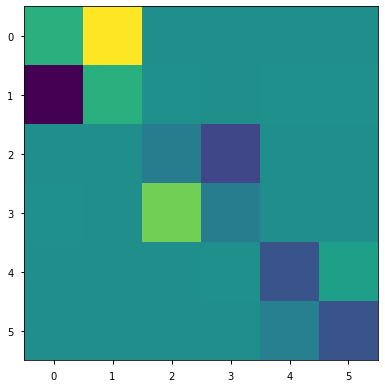

In [5]:
psi_ls = LA.inv(U1.conj().T @ U1) @ U1.conj().T @ U2

fig, ax = plt.subplots()
ax.imshow(psi_ls)
fig.tight_layout()

## Stima delle Frequenze Armoniche
Calcolo degli autovalori di $\Psi$ coincidenti con i versori rotanti associati alle frequenze armoniche.

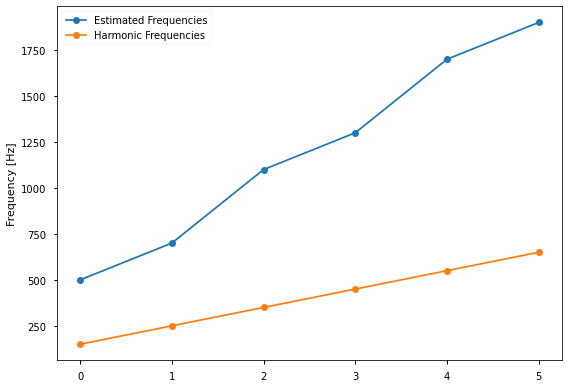

In [6]:
est_omegas = np.sort(np.angle(LA.eigvals(psi_ls)) % (2 * np.pi))
est_freqs = est_omegas * sampling_freq / (2 * np.pi)

fig, ax = plt.subplots()
ax.plot(est_freqs, 'o-', label='Estimated Frequencies')
ax.plot(power_freq * harmonic_numbers, 'o-', label='Harmonic Frequencies')
ax.set_ylabel('Frequency [Hz]')
ax.legend()
fig.tight_layout()